<a href="https://colab.research.google.com/github/pachterlab/CJP_2025/blob/main/notebooks/mouse-ds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/abidlabs/contrastive/refs/heads/master/experiments/datasets/Data_Cortex_Nuclear.csv

--2025-10-29 17:44:19--  https://raw.githubusercontent.com/abidlabs/contrastive/refs/heads/master/experiments/datasets/Data_Cortex_Nuclear.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1010613 (987K) [text/plain]
Saving to: ‘Data_Cortex_Nuclear.csv’

Data_Cortex_Nuclear 100%[===================>] 986.93K  --.-KB/s    in 0.1s    

2025-10-29 17:44:20 (6.50 MB/s) - ‘Data_Cortex_Nuclear.csv’ saved [1010613/1010613]



In [2]:
# install ccpa
!pip3 install contrastive

  Preparing metadata (setup.py) ... done
  Created wheel for contrastive: filename=contrastive-1.2.0-py3-none-any.whl size=6899 sha256=e551da20170d14b0d538c9ab4b204a05df9e7bb3f018e7969f2e4eebb337d884
  Stored in directory: /root/.cache/pip/wheels/c0/b5/06/f9cee153dd8a0cd9f13a325b1f8cae67bf546c2d83ca98d736
Successfully built contrastive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from contrastive import CPCA
from scipy.linalg import eigh

In [4]:
# adapted from https://github.com/abidlabs/contrastive/blob/master/experiments/Mice%20Protein%20(Figure%202).ipynb
data = np.genfromtxt('Data_Cortex_Nuclear.csv',delimiter=',',
                     skip_header=1,usecols=range(1,78),filling_values=0)
classes = np.genfromtxt('Data_Cortex_Nuclear.csv',delimiter=',',
                        skip_header=1,usecols=range(78,81),dtype=None)

In [5]:
target_idx_A = np.where((classes[:,-1]=='S/C') & (classes[:,-2]=='Saline') & (classes[:,-3]=='Control'))[0]
target_idx_B = np.where((classes[:,-1]=='S/C') & (classes[:,-2]=='Saline') & (classes[:,-3]=='Ts65Dn'))[0]

labels = len(target_idx_A)*[0] + len(target_idx_B)*[1]
target_idx = np.concatenate((target_idx_A,target_idx_B))

target = data[target_idx]

background_idx = np.where((classes[:,-1]=='C/S') & (classes[:,-2]=='Saline') & (classes[:,-3]=='Control'))
background = data[background_idx]


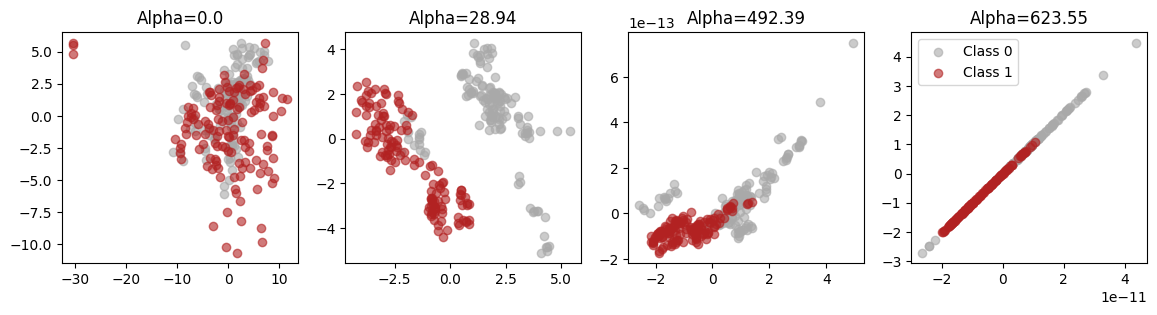

In [6]:
mdl = CPCA()
projected_data = mdl.fit_transform(target, background, plot=True, active_labels=labels, colors = ['darkgray','firebrick'])

In [7]:
# standardize
def standardize_array(array):
        standardized_array =  (array-np.mean(array,axis=0)) / np.std(array,axis=0)
        return np.nan_to_num(standardized_array)

target_std = standardize_array(target)
background_std = standardize_array(background)

In [8]:
# Rayleigh Quotient
# --- Rayleigh Quotient projection (2D) ---

Sigma_t = np.cov(target_std, rowvar=False)
Sigma_b = np.cov(background_std, rowvar=False)
eigvals_rq, eigvecs_rq = eigh(Sigma_t, Sigma_b)

# Take top 2 generalized eigenvectors
V_rq = eigvecs_rq[:, -2:]  # shape (30, 2)
target_proj_rq = target_std @ V_rq  # shape (400, 2)

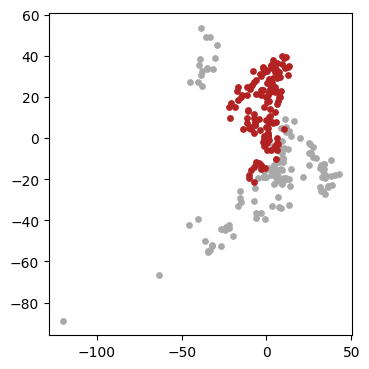

In [9]:
# plot these
# --- Plot Rayleigh projection scatterplot ---
plt.figure(figsize=(3.8, 3.8))
colors = ['darkgray', 'firebrick']
label_names = ['Non-DS','(Down syndrome) DS']
for i in [0,1]:
    idx = np.array(labels) == i
    plt.scatter(target_proj_rq[idx, 0], target_proj_rq[idx, 1], label=label_names[i], color=colors[i], s = 15)

# plt.title("Rayleigh Quotient Projection (Top 2 Components)")
# plt.xlabel("1st Generalized Eigenvector")
# plt.ylabel("2nd Generalized Eigenvector")
# plt.legend(loc='upper left')
# plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# silhuoette clustering method
from sklearn.metrics import silhouette_score
from sklearn import cluster

In [43]:
for a in [0.1,28.94,492.39,623.55]:

  mdl = CPCA()
  projected_cpca = mdl.fit_transform(target_std, background_std, alpha_selection='manual', alpha_value = a)

  ss_cpca = silhouette_score(projected_cpca, labels)
  print(a,ss_cpca)

0.1 0.15746702981021315
28.94 0.4199008346655074
492.39 0.3841975281894202
623.55 0.33893609323469753


In [42]:
ss_rayleigh = silhouette_score(target_proj_rq, labels)
ss_rayleigh

np.float64(0.28633807095768743)